# ARIMA Work

In [2]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import pickle
import matplotlib.pyplot as plt
from pymongo import MongoClient
import time
import datetime
import os
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import scipy.stats as scs
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings # We get some interger -> float typecast warning from sklean
warnings.filterwarnings('ignore')
def fromts(dt): return datetime.datetime.fromtimestamp(dt)
def tots(dt): return time.mktime(datetime.datetime.strptime(dt, "%b %d %Y").timetuple())
from plot_series_arima import fit_moving_average_trend, plot_raw, plot_moving_average, plot_resid

In [3]:
plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
with open('data/all_apps_df.pkl', 'rb') as f:
    df = pickle.load(f)

### Make _series_ a series of AK-47 | Redline (Field-Tested) sales after 2015 with dates as the index

In [6]:
df_gun = df[(df['item_name'] == 'AK-47 | Redline (Field-Tested)')]
df_gun.date = [datetime.datetime.fromtimestamp(t) for t in df_gun.date]
df_gun.index= df_gun.date
series = df_gun.median_sell_price
series = series.loc[pd.Timestamp('2015-01-01'):]

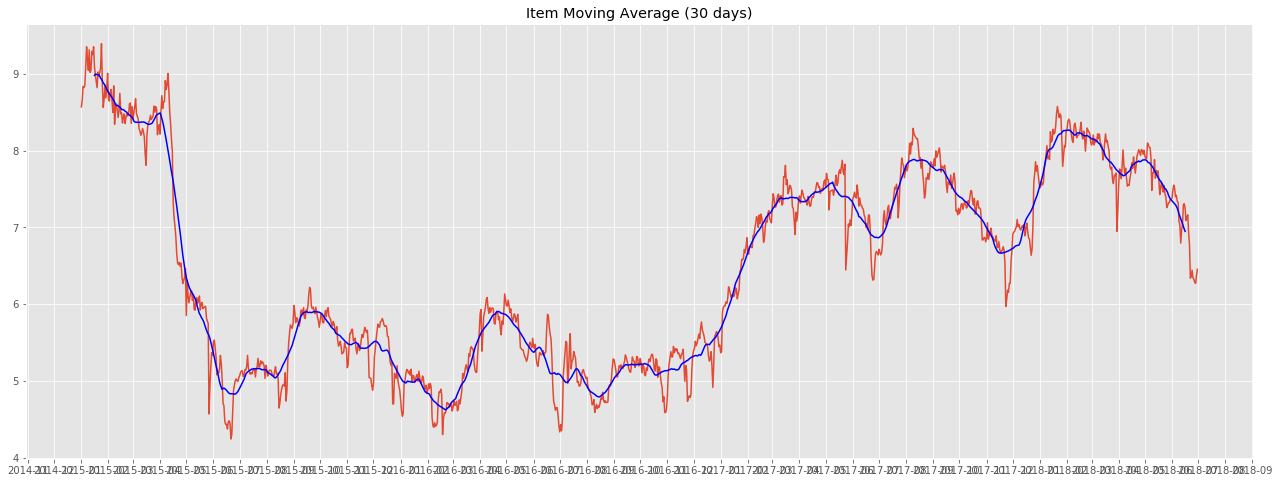

In [8]:
fig, ax = plt.subplots(figsize=(22, 8))
plot_moving_average(series, ax)